In [1]:
import json
import os
import itertools

import rootpath
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import geopandas as gpd
import pycountry as pc
import pycountry_convert as pcc

from lhledge import cfgLoader
from lhledge import lhlFilters
from lhledge import loadGeographicData

In [2]:
CYCLE = 10020
DOWNSAMPLING = 1

In [3]:
def ecdf(data, w=[]):
    """ Compute ECDF """
    if len(w) == 0:
        w = np.ones(len(data))
    #
    #     x = np.sort(data)
    idx = np.argsort(data).values
    #
    x = np.array(data)
    x = x[idx]
    w = w[idx]
    #
    n = x.size
    #     y = np.arange(1, n + 1) / n
    y = np.cumsum(w) / sum(w)
    return (np.squeeze(x), y)

In [4]:
def ecdf2(df, field, field_aux):
    df = df.sort_values(field)
    y = np.cumsum(df.groupby(field)["router_id"].count().values)
    y = y / max(y)
    x = df.drop_duplicates(field)[field].values
    return x, y

In [5]:
# Change directory to run from the root dir of the project
path = rootpath.detect(pattern=".git")
os.chdir(path)

# load config file
cfg = cfgLoader.cfgLoader("config.yml")

In [6]:
df = pd.read_csv(f"data/processed/snapshots/{CYCLE}.csv.gz", compression="gzip")

In [7]:
cepii = loadGeographicData.load_inter_country_distances("data/external/cepii/dist_cepii.csv", 
                                                        "data/processed/min-cc-dist/min_cc_dist.csv")
cepii.head()

,cc_src,cc_dst,dist
0,AW,AW,5.225315
1,AW,AF,13257.810000
2,AW,AO,9516.913000
3,AW,AI,983.268200
4,AW,AL,9091.742000


In [8]:
G = nx.from_pandas_edgelist(
   df.drop_duplicates(["near_node_id", "far_node_id",]),
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

nx.set_node_attributes(
    G,
    pd.Series(
        df["near_side_cc"].values,
        index=df["near_node_id"]
    ).to_dict(),
    'cc',
)
nx.set_node_attributes(
    G,
    pd.Series(
        df["far_side_cc"].values,
        index=df["far_node_id"]
    ).to_dict(),
    'cc',
)

In [9]:
all_vals = []
cc_list = []
rtt_vals = []
for n1, n2, weight  in G.edges(data=True):
    cc1 = G.nodes()[n1]["cc"]
    cc2 = G.nodes()[n2]["cc"]
    cc_str_1 = f"{cc1}-{cc2}"
    cc_str_2 = f"{cc2}-{cc1}"
    if (cc_str_1 not in cc_list) and (cc_str_2 not in cc_list):
        cc_list.append(cc_str_1)
    rtt_vals.append(weight["diff_rtt"])
    all_vals.append((cc1, cc2, weight["diff_rtt"]))

In [10]:
l = []

for str_cc in cc_list:
    cc1, cc2 = str_cc.split("-")
    l.append((cc1, cc2))

cc_graph = pd.DataFrame(l, columns=["cc1", "cc2"])
cc_graph = cc_graph.join(
    cepii[["cc_src", "cc_dst", "dist"]].set_index(["cc_src", "cc_dst"]),
    on=["cc1", "cc2"],
    how='left',
    lsuffix='_left',
    rsuffix='_right'
)
cc_graph.head()


,cc1,cc2,dist
0,AE,CH,4407.826551
1,CH,JP,9214.366906
2,AE,DE,4266.720006
3,DE,US,5297.217204
4,AE,US,10133.024219


In [11]:
all_vals = pd.DataFrame(all_vals, columns=["cc1", "cc2", "diff_rtt"])
all_vals = all_vals.join(
    cepii[["cc_src", "cc_dst", "dist"]].set_index(["cc_src", "cc_dst"]),
    on=["cc1", "cc2"],
    how='left',
    lsuffix='_left',
    rsuffix='_right'
)
all_vals.head()

,cc1,cc2,diff_rtt,dist
0,AE,CH,114.876,4407.826551
1,CH,JP,209.294,9214.366906
2,CH,JP,211.329,9214.366906
3,AE,DE,67.622,4266.720006
4,DE,US,80.180,5297.217204


In [12]:
H = nx.from_pandas_edgelist(
   cc_graph,
    "cc1",
    "cc2",
)

print(f"nodes: {len(G.nodes())}")
print(f"edges: {len(G.edges())}")
print(f"countries: {len(H.nodes())}")



nodes: 31773
edges: 85620
countries: 170


In [13]:
G0 = nx.from_pandas_edgelist(
   df.drop_duplicates(["near_node_id", "far_node_id",]),
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

In [14]:
G1 = nx.from_pandas_edgelist(
   df,
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

In [15]:
len(G0.edges())

85620

In [16]:
len(G1.edges())

85620

In [17]:
G = nx.from_pandas_edgelist(
   df.drop_duplicates(["near_node_id", "far_node_id",]),
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

nx.set_node_attributes(
    G,
    pd.Series(
        df["near_side_cc"].values,
        index=df["near_node_id"]
    ).to_dict(),
    'cc',
)
nx.set_node_attributes(
    G,
    pd.Series(
        df["far_side_cc"].values,
        index=df["far_node_id"]
    ).to_dict(),
    'cc',
)


In [18]:

hits = {}

for n1, n2, weight  in G.edges(data=True):
    cc1 = G.nodes()[n1]["cc"]
    cc2 = G.nodes()[n2]["cc"]

    cc1_3 = pc.countries.get(alpha_2=cc1).alpha_3
    cc2_3 = pc.countries.get(alpha_2=cc2).alpha_3

    if cc1_3 not in hits.keys():
        hits[cc1_3] = 0
    if cc2_3 not in hits.keys():
        hits[cc2_3] = 0

    hits[cc1_3] += 1
    hits[cc2_3] += 1

In [19]:
cc3_edges = pd.DataFrame(hits.items(), columns = ["iso_a3", "cnt"])
cc3_edges.head()

,iso_a3,cnt
0,ARE,141
1,CHE,1339
2,JPN,1497
3,DEU,30906
4,USA,68432


In [20]:
r = pd.DataFrame(rtt_vals, columns=["rtt"])["rtt"]

In [21]:
r[(r > 50) & (r < 135)].size / r.size

0.5274468582106985

In [22]:
np.percentile(r, [90,])

array([202.0005])

In [23]:
cc_graph.loc[cc_graph["dist"] > 1600].sort_values("dist")

,cc1,cc2,dist
221,TR,FR,1624.218125
429,BR,DO,1624.244730
54,CR,BR,1625.812472
16,US,CO,1671.006273
729,IL,IT,1679.876822
...,...,...,...
632,PE,SG,18825.880000
605,CO,SG,19364.400000
68,ID,CO,19515.576477
1108,KR,UY,19629.500000


In [24]:
d = cc_graph.loc[cc_graph["dist"] > 0]["dist"]

In [25]:
np.percentile(d, [90,])

array([13140.12530378])

In [26]:
cc_graph

,cc1,cc2,dist
0,AE,CH,4407.826551
1,CH,JP,9214.366906
2,AE,DE,4266.720006
3,DE,US,5297.217204
4,AE,US,10133.024219
...,...,...,...
1111,SE,BT,6126.209823
1112,SK,GW,4863.081320
1113,UA,GE,420.365010
1114,UA,UZ,1273.707974


In [27]:
def _get_cont(cc):
    country = pc.countries.get(alpha_2=cc)
    continent = pcc.country_alpha2_to_continent_code(country.alpha_2)
    
    return continent

def get_cont_pairs(G):

    cont_vals = []

    for n1, n2, weight  in G.edges(data=True):
        cont1 = _get_cont(G.nodes()[n1]["cc"])
        cont2 = _get_cont(G.nodes()[n2]["cc"])
                
        if cont1 > cont2:
            cont1, cont2 = cont2, cont1
            
        cont_str_1 = f"{cont1}-{cont2}"
        
        cont_vals.append(cont_str_1)
    
    return cont_vals


def get_continent_rtts(G, src_cont):
   
    rtt_vals = []
    
    for n1, n2, weight in G.edges(data=True):
        cont1 = _get_cont(G.nodes()[n1]["cc"])
        cont2 = _get_cont(G.nodes()[n2]["cc"])
        
        if cont1 == src_cont or cont2 == src_cont:
                
            if cont1 > cont2:
                cont1, cont2 = cont2, cont1

            cont_str_1 = f"{cont1}-{cont2}"


            rtt_vals.append((cont_str_1, weight["diff_rtt"]))
    
    return rtt_vals

In [28]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

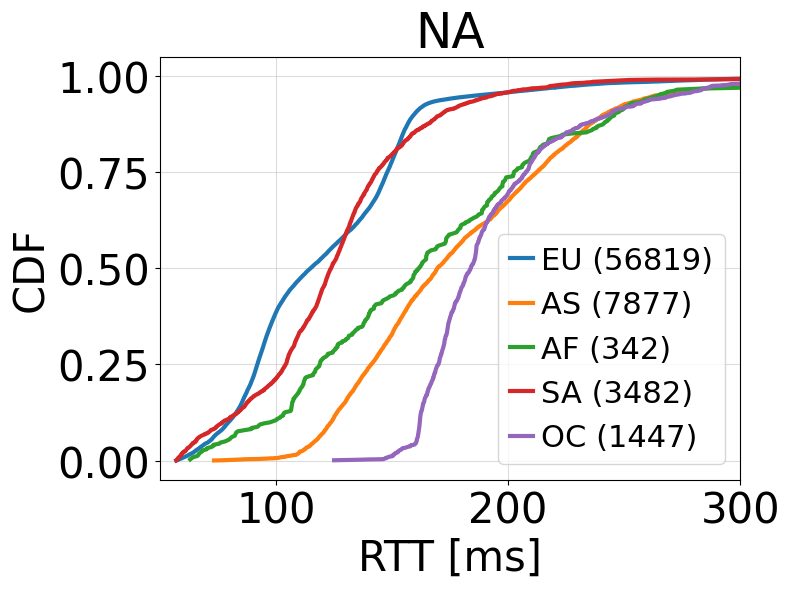

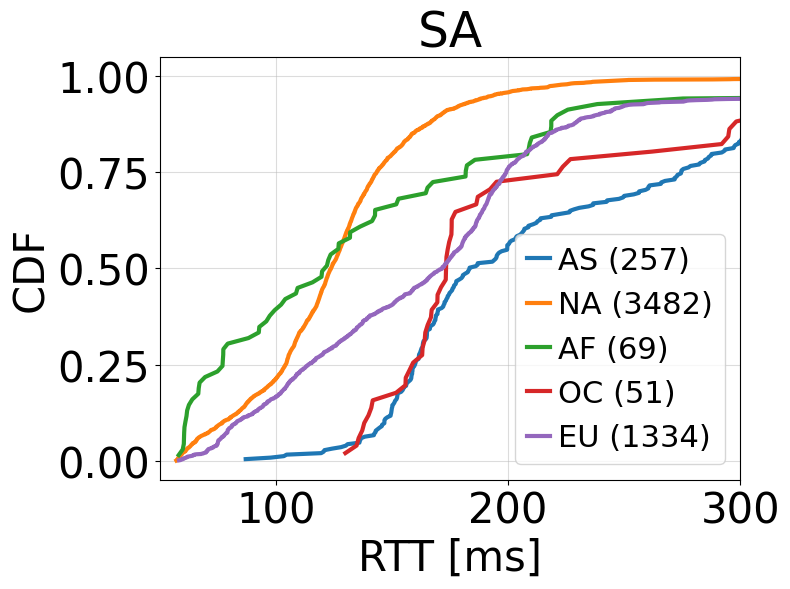

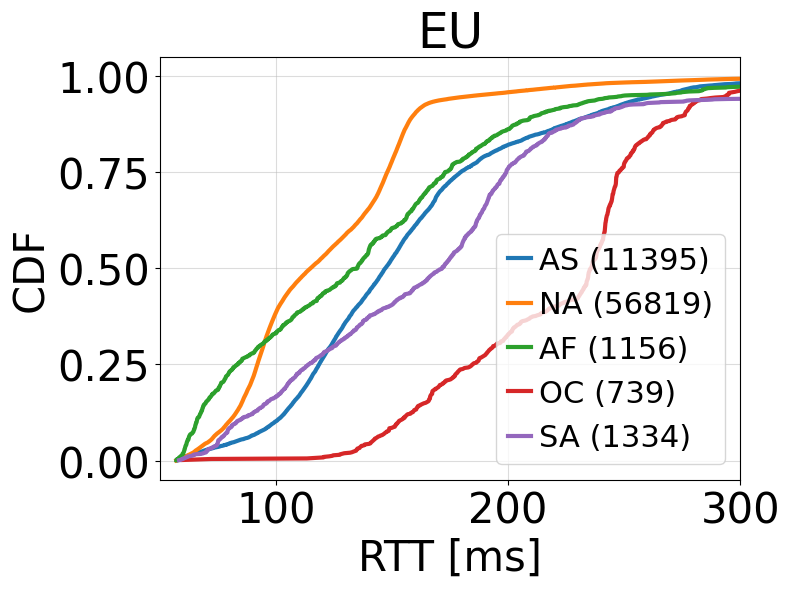

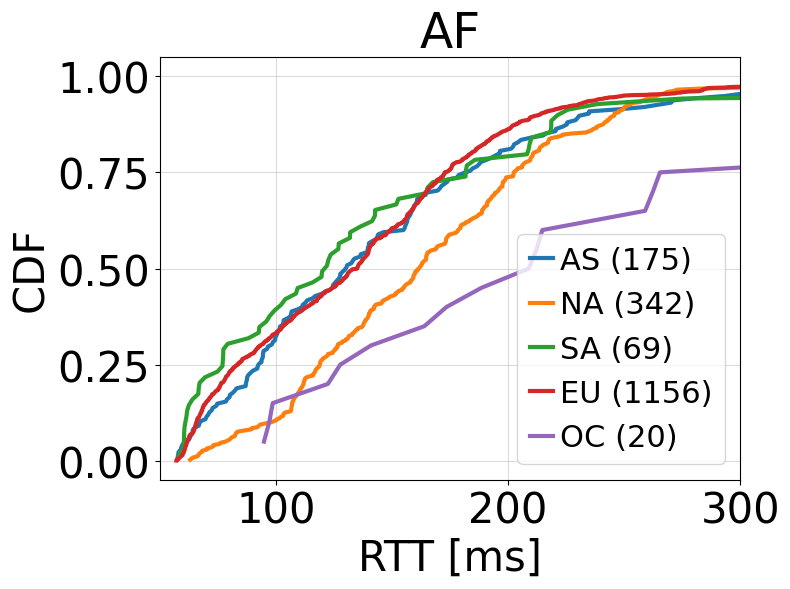

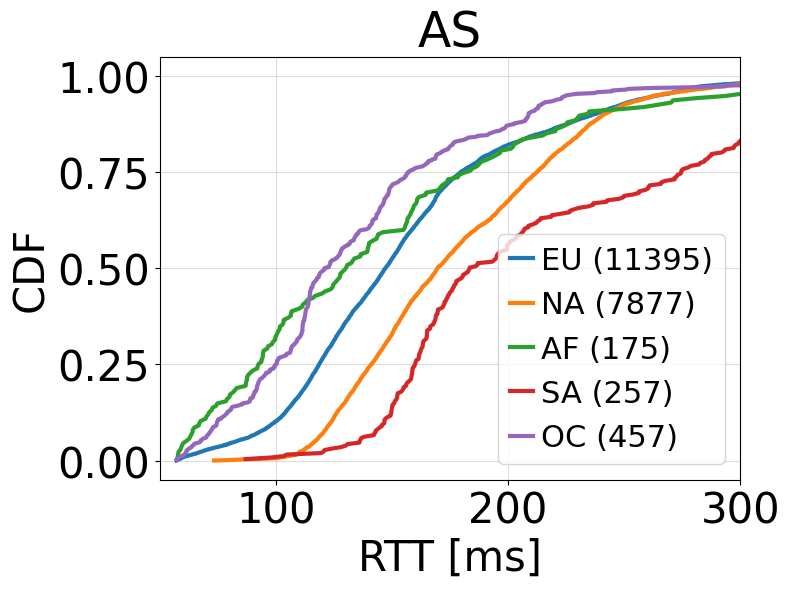

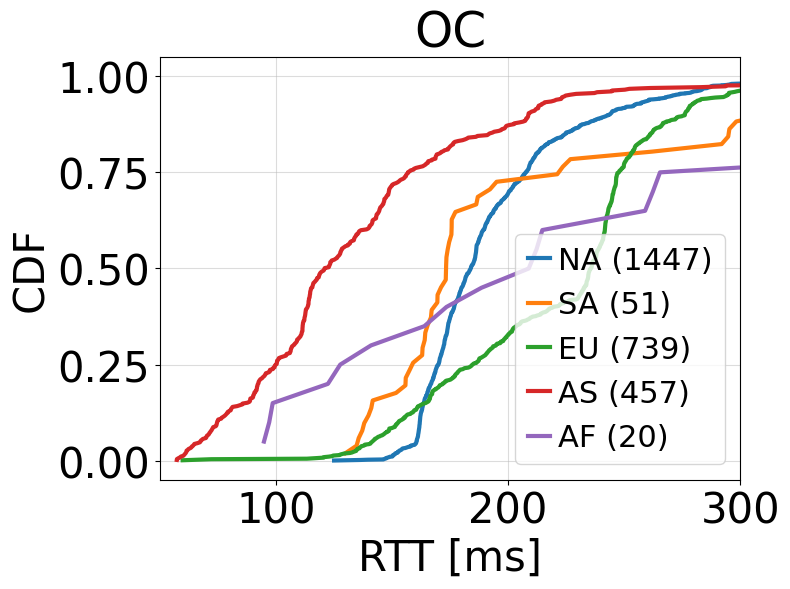

In [29]:
for src_cont in ["NA", "SA", "EU", "AF", "AS", "OC"]:
    
    fig, ax = plt.subplots(1, figsize=(8, 6), sharex=True, sharey=True)
    
    ax.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
    ax.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')

    markers = itertools.cycle(["o", "d", "s"])
    
    
    
    rtts = get_continent_rtts(G, src_cont)
    df = pd.DataFrame(rtts, columns=["cont", "rtt"])
    

    for cont in df.drop_duplicates("cont")["cont"].values:
    
        x, y = ecdf(df.loc[df["cont"] == cont]["rtt"])
        cont_label = cont.replace(f"-{src_cont}", "").replace(f"{src_cont}-", "")
        ax.plot(x, y, label=f'{cont_label} ({len(x)})', lw=3)
    
    
    ax.legend(loc='lower right', ncol=1, frameon=True, fontsize=22,
              handletextpad=0.25, columnspacing=0.5, handlelength=0.75)
    
    ax.set_title(f"{src_cont}", fontsize=35)

    ax.set_xlim(50, 300)
    
    # ax.set_ylabel('CDF', fontsize=20)
    
    ax.set_xlabel('RTT [ms]', fontsize=30)
    ax.set_ylabel('CDF', fontsize=30)
        
    ax.tick_params(labelsize=30)
    
    fig.subplots_adjust(hspace=0)
    fig.tight_layout()
    # fig.savefig(f"figures/ulh-prevalence/lhl_dist_breakdown_{src_cont}.pdf")